In [16]:
import os, math
from tensorflow.keras.layers import Dropout, Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_absolute_error, r2_score

plt.rcParams['axes.unicode_minus'] = False    

In [17]:
def get_middle_number(filename):
    return int(filename.split('_')[0][7:])

In [18]:
directory = 'Stations/'
sh_w_files = [filename for filename in os.listdir(directory) if filename.endswith('.csv') and filename[-5] == '1']
de_w_files = [filename for filename in os.listdir(directory) if filename.endswith('.csv') and filename[-5] == '2']

sh_w_files.sort(key=get_middle_number)
de_w_files.sort(key=get_middle_number)

In [4]:
#fig = plt.figure(figsize=(10,320),dpi=55)

# Comparsion of all models for each stations

In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.layers import Dropout, Dense, SimpleRNN, BatchNormalization
from sklearn.ensemble import GradientBoostingRegressor
import tensorflow as tf
import autokeras as ak
from keras.models import Sequential
from keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping

plt.rcParams['axes.unicode_minus'] = False

def get_middle_number(filename):
    return int(filename.split('_')[0][7:])

def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path)
    df = pd.DataFrame(data.iloc[:, 3:], dtype=float)
    df = df.iloc[:, :]

    X = df.values
    Y = df.iloc[:, -1].values

    sc = MinMaxScaler(feature_range=(0, 1))
    X = sc.fit_transform(X[:, 0:-1])

    x_train = []
    y_train = []

    x_test = []
    y_test = []

    for k in range(14, int(df.shape[0] * 0.75)):
        x_train.append(X[k - 14:k, :])
        y_train.append(Y[k])

    for p in range(14, df.shape[0] - int(df.shape[0] * 0.75)):
        x_test.append(X[p - 14:p, :])
        y_test.append(Y[p])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_test, y_test = np.array(x_test), np.array(y_test)

    return x_train, y_train, x_test, y_test, data

def rnn_model(x_train, y_train, x_test, y_test):
    x_train = np.reshape(x_train, (x_train.shape[0], 14, int(x_train.size/(x_train.shape[0]*14))))
    x_test = np.reshape(x_test, (x_test.shape[0], 14, int(x_test.size/(x_test.shape[0]*14))))

    model = tf.keras.Sequential([
        SimpleRNN(100, return_sequences=True),
        Dropout(0.1),
        SimpleRNN(100),
        Dense(1)
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                  loss='mean_squared_error')

    history = model.fit(x_train, y_train,
                        batch_size=32,
                        epochs=200,
                        validation_data=(x_test, y_test),
                        validation_freq=1,
                        validation_split=0.25)

    predicted = model.predict(x_test)

    return predicted

def gradient_boosting_model(x_train, y_train, x_test, y_test):
    x_train = np.reshape(x_train, (x_train.shape[0], -1))
    x_test = np.reshape(x_test, (x_test.shape[0], -1))

    gb_model = GradientBoostingRegressor(n_estimators=100, random_state=32, validation_fraction=0.25)
    gb_model.fit(x_train, y_train)

    predicted = gb_model.predict(x_test)

    return predicted

def mlp_model(x_train, y_train, x_test, y_test):
    x_train = np.reshape(x_train, (x_train.shape[0], -1))
    x_test = np.reshape(x_test, (x_test.shape[0], -1))

    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    model = Sequential([
        Dense(128, activation='relu', input_dim=x_train_scaled.shape[1]),
        BatchNormalization(),
        Dropout(0.2),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    history = model.fit(x_train_scaled, y_train, epochs=300, batch_size=64, validation_split=0.25, callbacks=[early_stopping])

    predicted = model.predict(x_test_scaled)

    return predicted

def autokeras_model(x_train, y_train, x_test, y_test):
    x_train = np.reshape(x_train, (x_train.shape[0], -1))
    x_test = np.reshape(x_test, (x_test.shape[0], -1))

    reg = ak.StructuredDataRegressor(overwrite=True, max_trials=10)
    reg.fit(x_train, y_train, epochs=300, validation_split=0.25)

    predicted = reg.predict(x_test)

    return predicted

def lstm_model(x_train, y_train, x_test, y_test):
    model = Sequential([
        LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])),
        Dropout(0.2),
        LSTM(100),
        Dense(1)
    ])

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Train the model
    model.fit(x_train, y_train, epochs=200, batch_size=32, validation_split=0.25, verbose=0)

    # Predict using the LSTM model
    predicted = model.predict(x_test)

    return predicted

#def plot_comparison(time_values, y_test, model_predictions, model_names, station_name):
    #plt.figure(figsize=(10, 6))

    #plt.plot(time_values, y_test, color='black', label='Observation')

    #for predictions, model_name in zip(model_predictions, model_names):
        #predictions = predictions[:len(time_values)]
        #plt.plot(time_values, predictions, label=model_name)

    #plt.xticks(time_values[::30])
    #plt.axhline(2, color="black", linestyle=':')
    #plt.title(f'{station_name}')
    #plt.xlabel('Time', fontsize=12, fontweight='bold')
    #plt.ylabel('DO (mg/L)', fontsize=12, fontweight='bold')
    #plt.legend(loc='upper right')
    #plt.tight_layout()
    #plt.show()
    
def plot_comparison(time_values, y_test, model_predictions, model_names, station_name, show_legend=True):
    plt.figure(figsize=(10, 6))

    plt.plot(time_values, y_test, color='black', label='Observation')

    for predictions, model_name in zip(model_predictions, model_names):
        predictions = predictions[:len(time_values)]
        plt.plot(time_values, predictions, label=model_name)

    plt.xticks(time_values[::30],fontsize=14,fontweight='bold' )
    plt.axhline(2, color="black", linestyle=':')
    plt.title(f'{station_name}',fontsize=16, fontweight='bold' )
    #plt.xlabel(fontsize=15, fontweight='bold')
    plt.ylabel('DO (mg/L)', fontsize=14, fontweight='bold')
    
    if show_legend:
        plt.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()



Trial 10 Complete [00h 00m 17s]
val_loss: 6.375727653503418

Best val_loss So Far: 3.918651580810547
Total elapsed time: 00h 02m 00s
INFO:tensorflow:Oracle triggered exit
Epoch 1/300
12/12 [==============================] - 2s 6ms/step - loss: 60.1793 - mean_squared_error: 60.1793
Epoch 2/300
12/12 [==============================] - 0s 6ms/step - loss: 40.7390 - mean_squared_error: 40.7390
Epoch 3/300
12/12 [==============================] - 0s 6ms/step - loss: 26.1227 - mean_squared_error: 26.1227
Epoch 4/300
12/12 [==============================] - 0s 6ms/step - loss: 13.9511 - mean_squared_error: 13.9511
Epoch 5/300
12/12 [==============================] - 0s 6ms/step - loss: 6.3236 - mean_squared_error: 6.3236
Epoch 6/300
12/12 [==============================] - 0s 6ms/step - loss: 3.7422 - mean_squared_error: 3.7422
Epoch 7/300
12/12 [==============================] - 0s 6ms/step - loss: 2.9764 - mean_squared_error: 2.9764
Epoch 8/300
12/12 [==============================] - 0s 6m

12/12 [==============================] - 0s 6ms/step - loss: 0.0878 - mean_squared_error: 0.0878
Epoch 148/300
12/12 [==============================] - 0s 6ms/step - loss: 0.0671 - mean_squared_error: 0.0671
Epoch 149/300
12/12 [==============================] - 0s 6ms/step - loss: 0.0523 - mean_squared_error: 0.0523
Epoch 150/300
12/12 [==============================] - 0s 6ms/step - loss: 0.0431 - mean_squared_error: 0.0431
Epoch 151/300
12/12 [==============================] - 0s 6ms/step - loss: 0.0464 - mean_squared_error: 0.0464
Epoch 152/300
12/12 [==============================] - 0s 6ms/step - loss: 0.0450 - mean_squared_error: 0.0450
Epoch 153/300
12/12 [==============================] - 0s 6ms/step - loss: 0.0440 - mean_squared_error: 0.0440
Epoch 154/300
12/12 [==============================] - 0s 6ms/step - loss: 0.0346 - mean_squared_error: 0.0346
Epoch 155/300
12/12 [==============================] - 0s 6ms/step - loss: 0.0273 - mean_squared_error: 0.0273
Epoch 156/300
1

12/12 [==============================] - 0s 6ms/step - loss: 0.0502 - mean_squared_error: 0.0502
Epoch 294/300
12/12 [==============================] - 0s 6ms/step - loss: 0.0380 - mean_squared_error: 0.0380
Epoch 295/300
12/12 [==============================] - 0s 6ms/step - loss: 0.0346 - mean_squared_error: 0.0346
Epoch 296/300
12/12 [==============================] - 0s 6ms/step - loss: 0.0424 - mean_squared_error: 0.0424
Epoch 297/300
12/12 [==============================] - 0s 6ms/step - loss: 0.0562 - mean_squared_error: 0.0562
Epoch 298/300
12/12 [==============================] - 0s 6ms/step - loss: 0.0520 - mean_squared_error: 0.0520
Epoch 299/300
12/12 [==============================] - 0s 6ms/step - loss: 0.0415 - mean_squared_error: 0.0415
Epoch 300/300
12/12 [==============================] - 0s 6ms/step - loss: 0.0421 - mean_squared_error: 0.0421
INFO:tensorflow:Assets written to: .\structured_data_regressor\best_model\assets
4/4 [==============================] - 0s 6ms

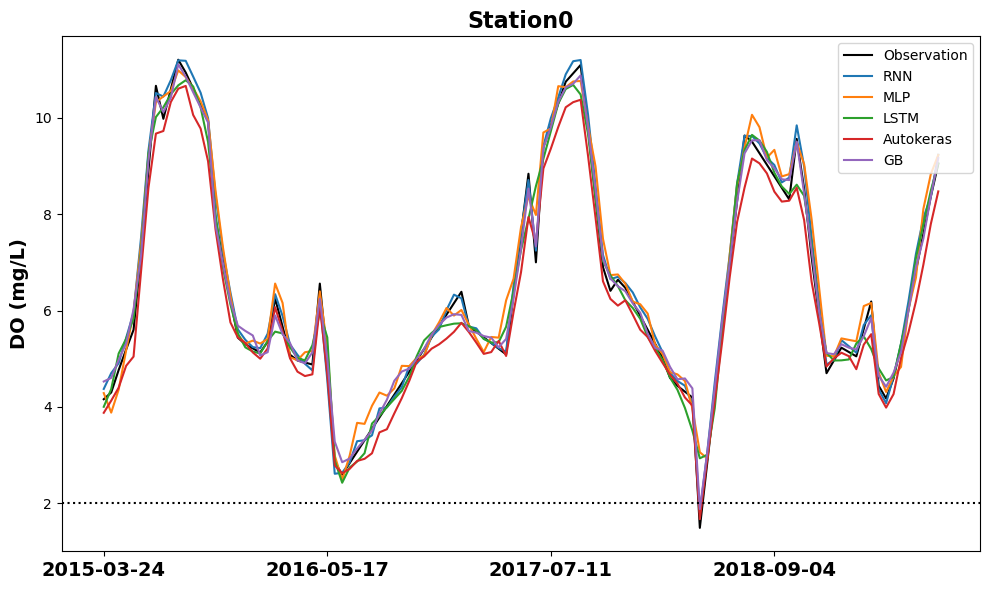

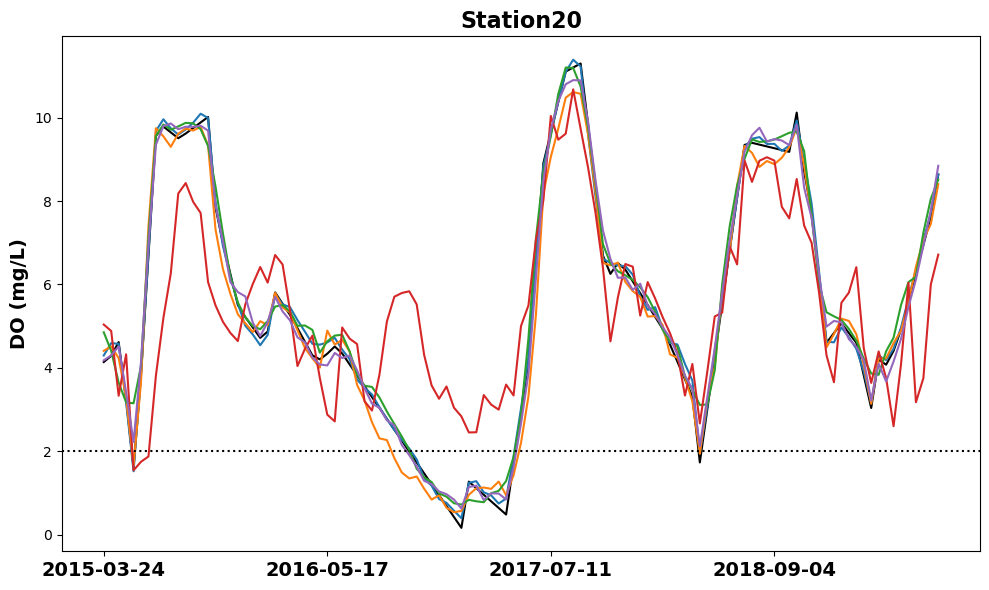

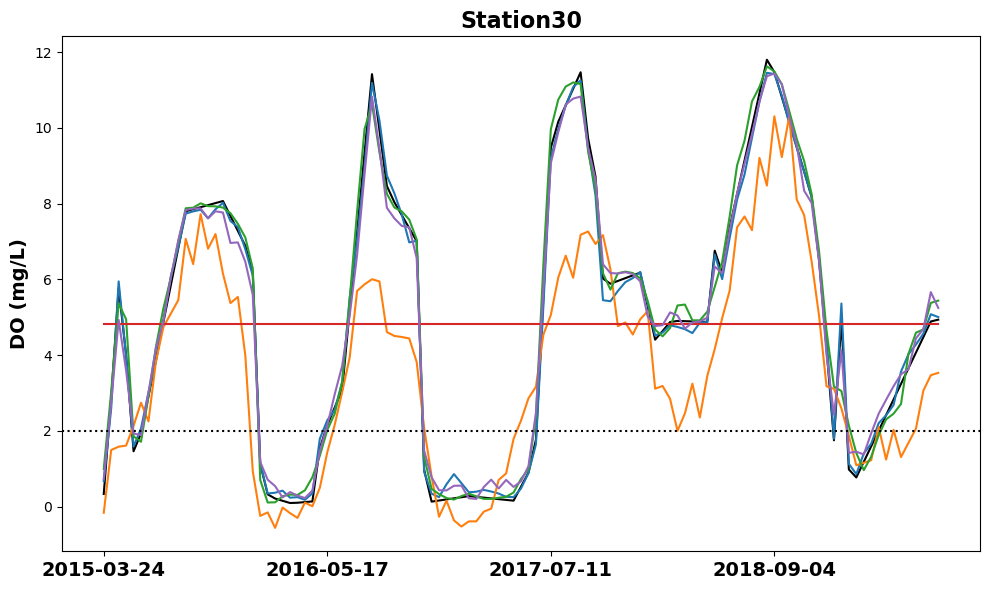

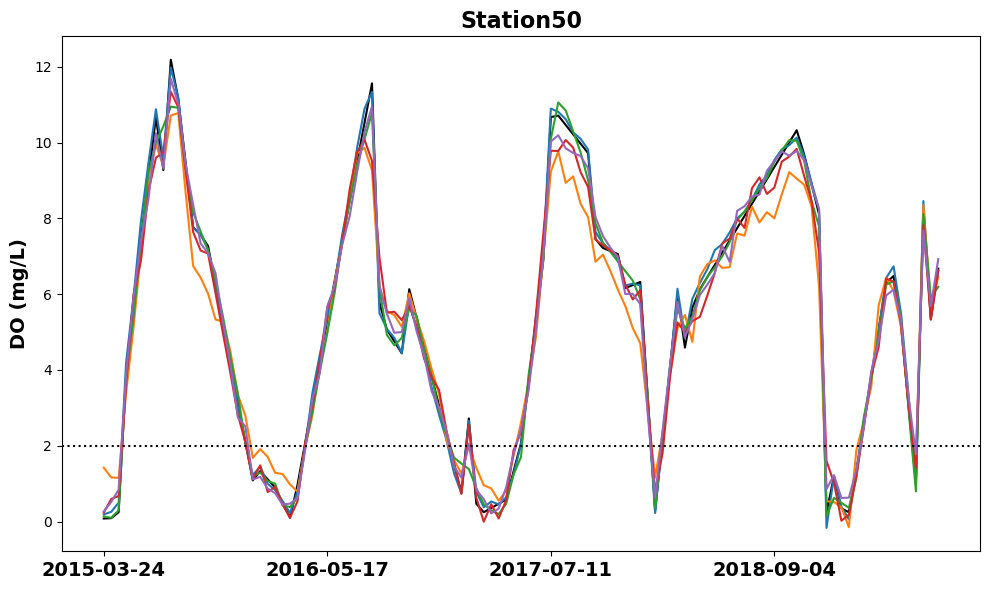

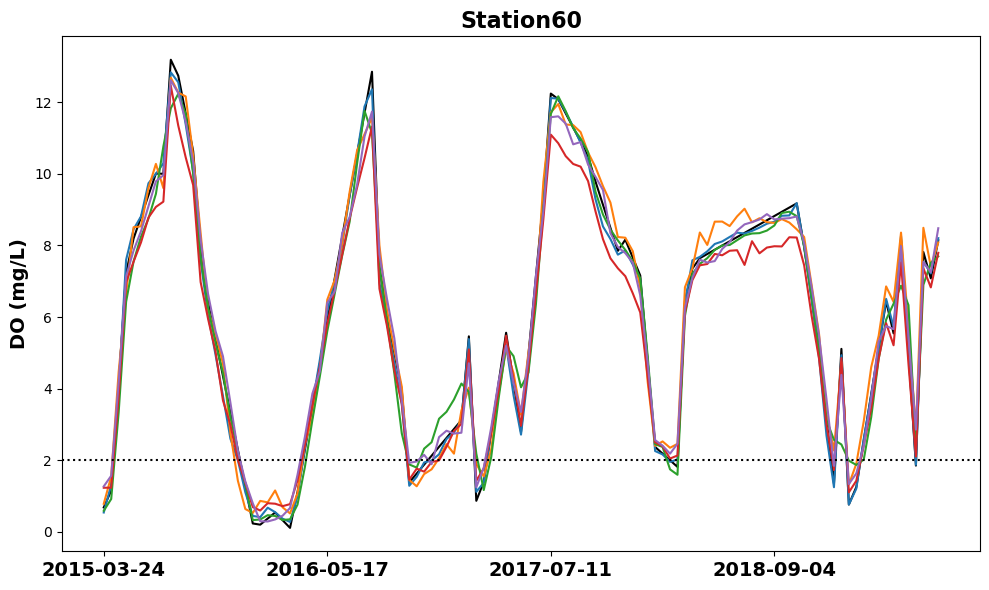

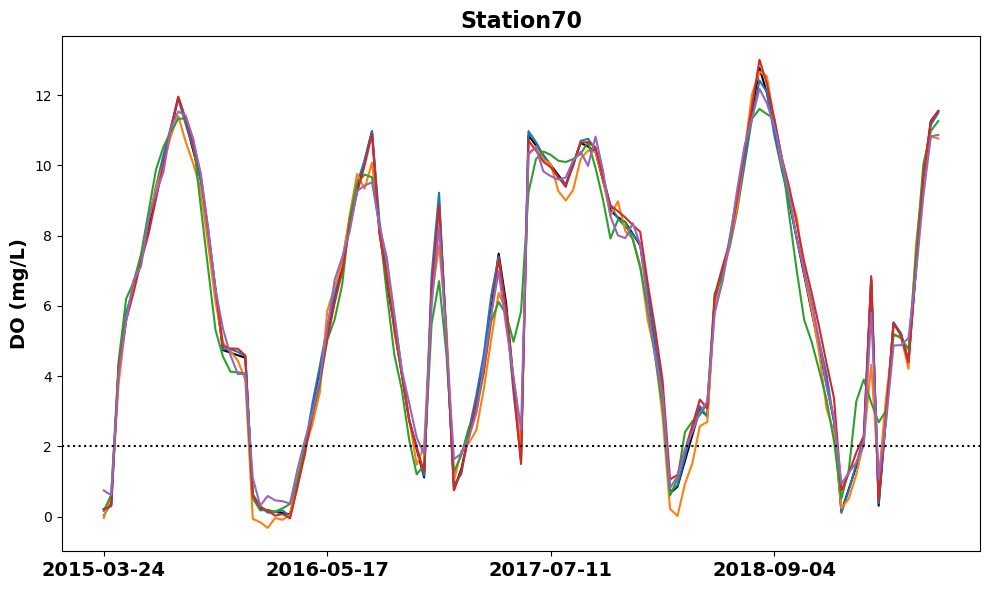

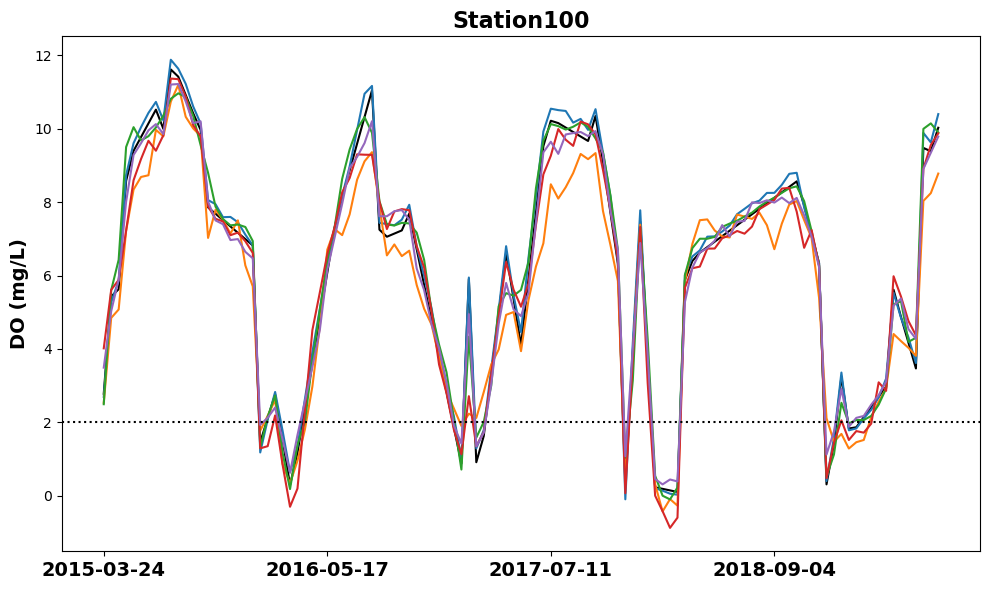

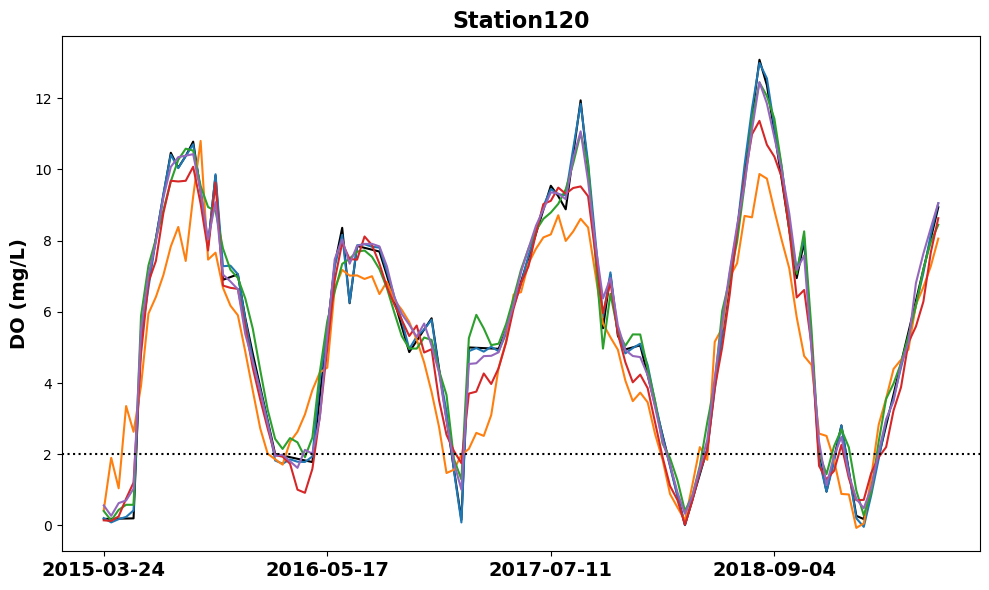

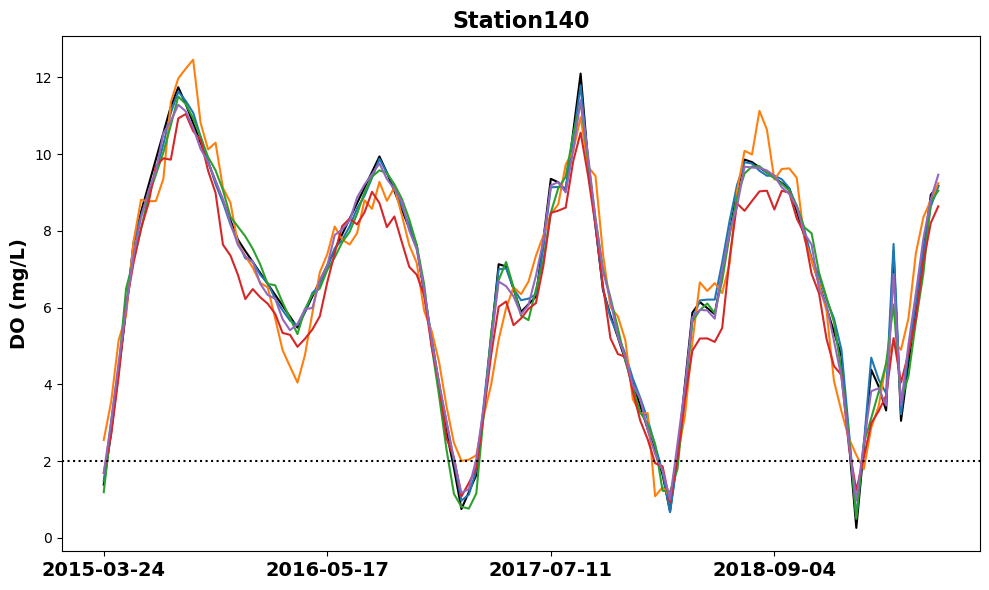

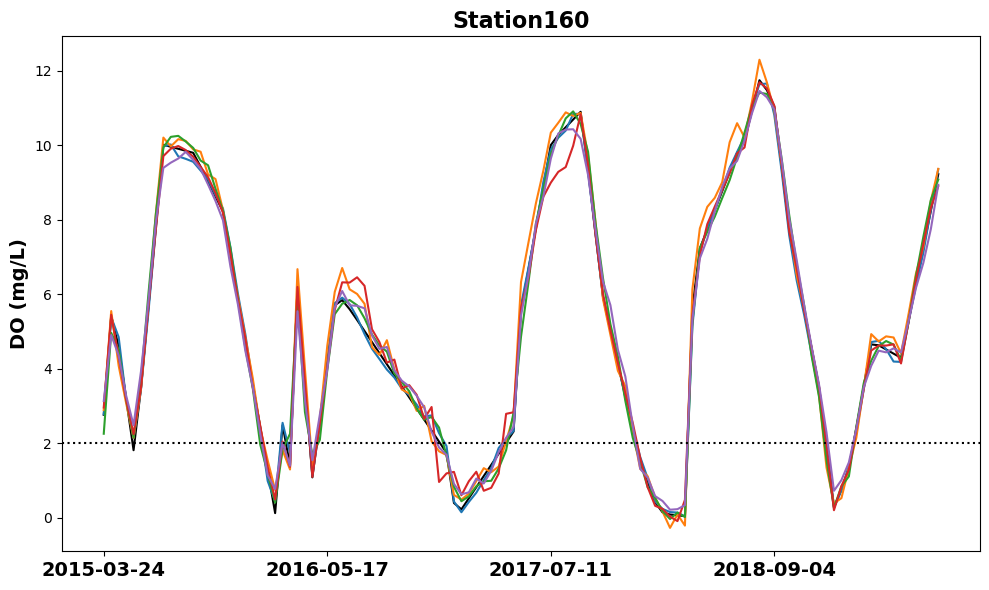

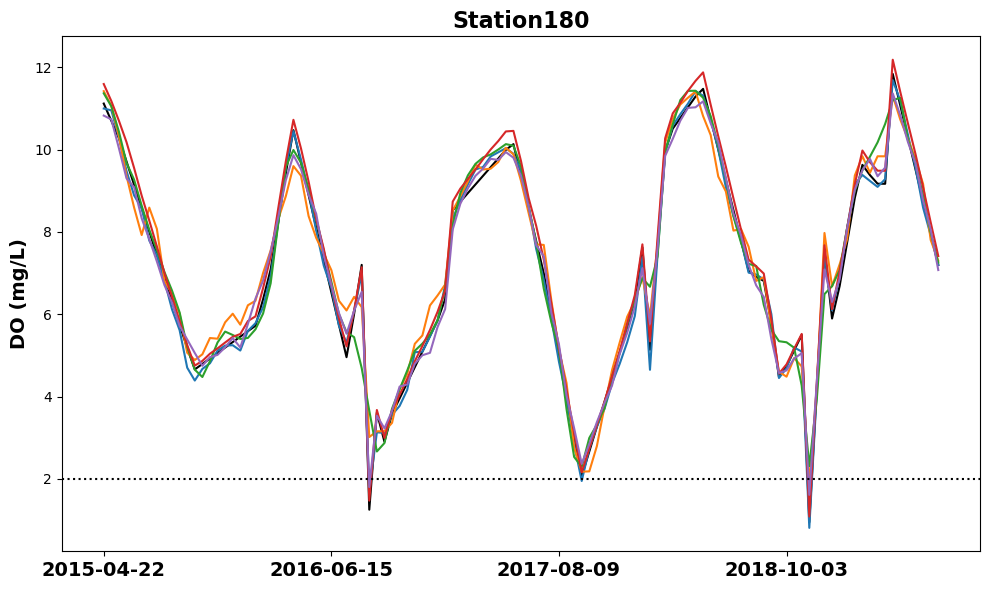

Station: Station0, File: Station0_2.csv
Model: RNN, MAE: 0.16941810797129456, R2: 0.9915057729130221
Model: MLP, MAE: 0.26585533722241206, R2: 0.974526726060059
Model: LSTM, MAE: 0.22987634796559772, R2: 0.9751617720629062
Model: Autokeras, MAE: 0.3311680329295525, R2: 0.9678500227640755
Model: GB, MAE: 0.15533138751849945, R2: 0.9925691207079604
Station: Station20, File: Station20_2.csv
Model: RNN, MAE: 0.12116054523559176, R2: 0.9972720837029287
Model: MLP, MAE: 0.27613776663534223, R2: 0.9845343709009304
Model: LSTM, MAE: 0.2772103736092643, R2: 0.9826086549021213
Model: Autokeras, MAE: 1.3688525320558684, R2: 0.622319494109567
Model: GB, MAE: 0.19014522503453157, R2: 0.9935950691405669
Station: Station30, File: Station30_2.csv
Model: RNN, MAE: 0.16607441891650973, R2: 0.996369947587793
Model: MLP, MAE: 1.5514127557081698, R2: 0.6812965368905293
Model: LSTM, MAE: 0.30678583023827477, R2: 0.9854505851502329
Model: Autokeras, MAE: 2.993387101083267, R2: -0.0010447256813781447
Model: G

In [11]:
directory = 'Stations/'
de_w_files = [filename for filename in os.listdir(directory) if filename.endswith('.csv') and filename[-5] == '2']
de_w_files.sort(key=get_middle_number)

model_functions = [rnn_model, mlp_model, lstm_model, autokeras_model, gradient_boosting_model]
model_names = ['RNN', 'MLP', 'LSTM', 'Autokeras', 'GB']  

station_data = {}
mae_list = [[] for _ in range(len(model_names))]
r2_list = [[] for _ in range(len(model_names))]

for i in range(0, len(de_w_files)):  
    file_name = de_w_files[i]
    base_name = file_name.split("_")[0]
    x_train, y_train, x_test, y_test, data = load_and_preprocess_data(os.path.join(directory, de_w_files[i]))

    predictions = []
    for j, model_function in enumerate(model_functions):  
        predicted = model_function(x_train, y_train, x_test, y_test)
        
        mae = mean_absolute_error(y_test, predicted)
        r2 = r2_score(y_test, predicted)

        mae_list[j].append(mae)  
        r2_list[j].append(r2)     
        
        predictions.append(predicted)

    time_values = pd.to_datetime(data.loc[data.index[-len(y_test):], 'Date']).dt.strftime('%Y-%m-%d')

    station_data[base_name] = {
        'time_values': time_values,
        'y_test': y_test,
        'predictions': predictions,
        'model_names': model_names
        }

    
for i, (station, data) in enumerate(station_data.items()):
    if i == 0:
        plot_comparison(data['time_values'], data['y_test'], data['predictions'], data['model_names'], station)
    else:
        plot_comparison(data['time_values'], data['y_test'], data['predictions'], data['model_names'], station, show_legend=False)
    
    
for i in range(len(de_w_files)):
    file_name = de_w_files[i]
    base_name = file_name.split("_")[0]

    print(f"Station: {base_name}, File: {file_name}")
    for j in range(len(model_names)):
         print(f"Model: {model_names[j]}, MAE: {mae_list[j][i]}, R2: {r2_list[j][i]}")